# Generative Advarsarial Network 

Here is presented the first GAN created by Ian Goodfellow https://arxiv.org/abs/1406.2661

Implementation is done in tensorflow

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


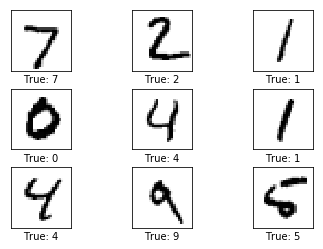

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")
ut.plot_mnist_images(mnist.test.images[0:9],cls_true=mnist.test.labels[0:9])

#reset graph using during notebook development
tf.reset_default_graph()



### Generator network 
In this implementation i use tensorflow layers API for creating the network

The network receive a 100-dimensinal vector (z) and return a 728-vector (same size of mnist image (28x28)). The objective is the generator create a mapping between space of vector z and the real MNIST DATA! (i think :P)

In [3]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
z_dimention = 100

G_dimentions = [z_dimention,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')

def generator(x):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :return: tensor with shape (M,728) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):
        g_net = tf.layers.dense(x,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE)
        return g_net


### Discriminator network 
In this implementation i use tensorflow layers API for creating the network

The network receives a image (728 vector) and try classify as fake or original.

In [4]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput 1-fake, 0-true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,728) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        d_net = tf.layers.dense(x,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Optimizers of tensorflow dont have maximizing method so we minimize the negative loss.

In [5]:

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): #D(G(Z))
    generated_sample = generator(Z)
    d_fake_prob, d_fake_logits = discriminator(generated_sample)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob, d_true_logits = discriminator(X)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits, labels=tf.ones_like(d_true_logits)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
        d_loss = d_loss_fake + d_loss_true
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))


#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

Since we dont want to obtimize the discriminator when training de generator and vice-versa

In [6]:
#
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)



[<tf.Variable 'g_hidden1/kernel:0' shape=(100, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm


Epoach 0
Discriminator loss:  1.66318
Generator loss: 1.61678


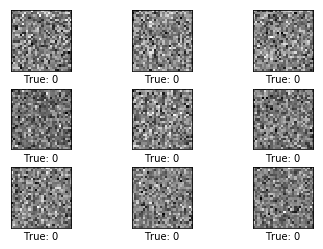

Epoach 1000
Discriminator loss:  0.0627929
Generator loss: 5.02017


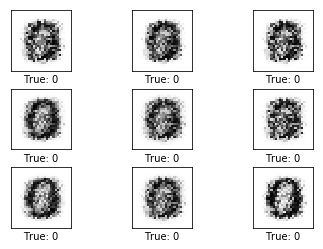

Epoach 2000
Discriminator loss:  0.0365065
Generator loss: 5.16926


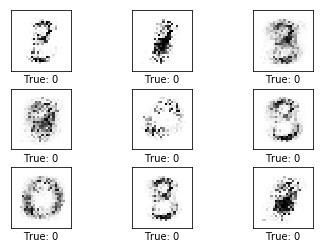

Epoach 3000
Discriminator loss:  0.327935
Generator loss: 5.08272


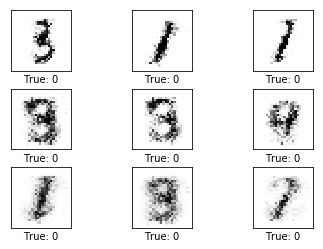

Epoach 4000
Discriminator loss:  0.130028
Generator loss: 5.74467


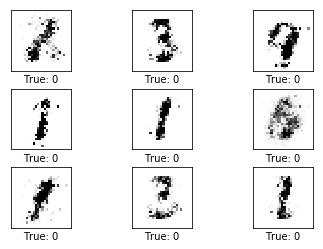

Epoach 5000
Discriminator loss:  0.217884
Generator loss: 5.02952


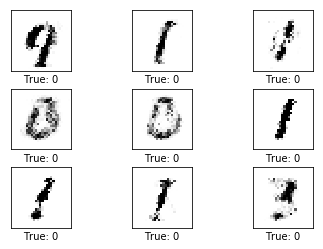

Epoach 6000
Discriminator loss:  0.471901
Generator loss: 3.8513


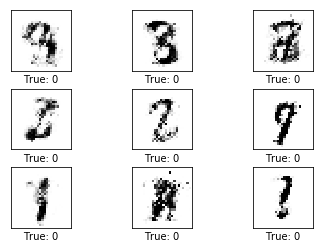

Epoach 7000
Discriminator loss:  0.502018
Generator loss: 3.75554


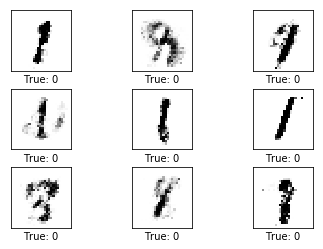

Epoach 8000
Discriminator loss:  0.421285
Generator loss: 3.11813


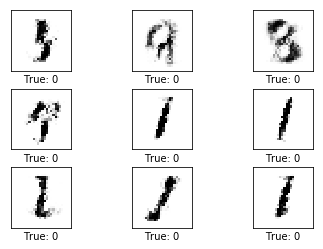

Epoach 9000
Discriminator loss:  0.54893
Generator loss: 3.32122


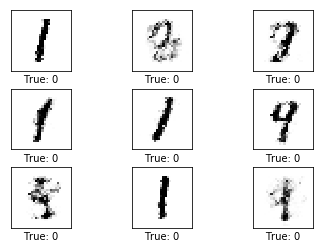

Epoach 10000
Discriminator loss:  0.500792
Generator loss: 3.03562


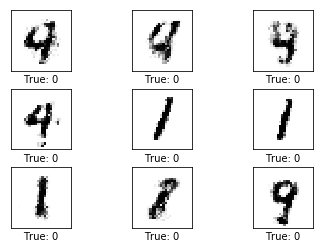

Epoach 11000
Discriminator loss:  0.708569
Generator loss: 2.47828


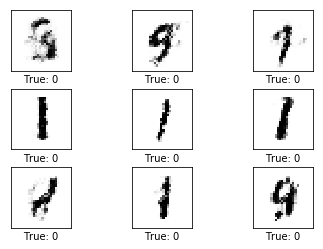

Epoach 12000
Discriminator loss:  0.545916
Generator loss: 2.92537


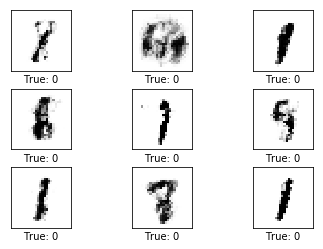

Epoach 13000
Discriminator loss:  0.502721
Generator loss: 2.50175


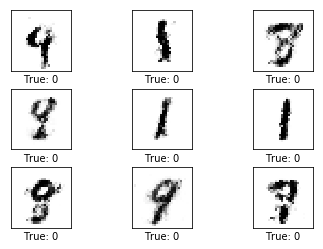

Epoach 14000
Discriminator loss:  0.650996
Generator loss: 2.5064


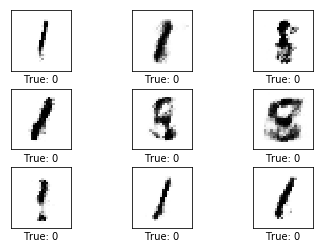

Epoach 15000
Discriminator loss:  0.653135
Generator loss: 2.03809


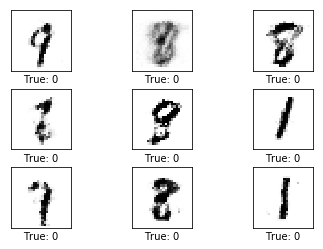

Epoach 16000
Discriminator loss:  0.639687
Generator loss: 2.2984


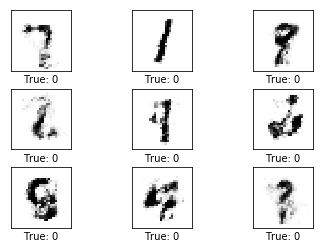

Epoach 17000
Discriminator loss:  0.555543
Generator loss: 2.63604


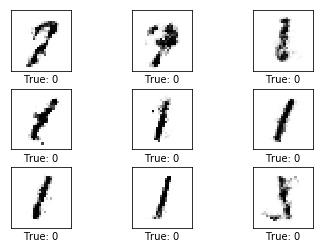

Epoach 18000
Discriminator loss:  0.706882
Generator loss: 2.24642


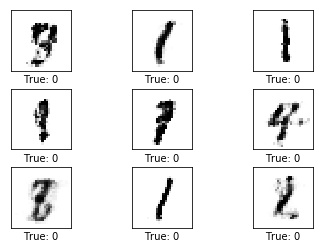

Epoach 19000
Discriminator loss:  0.642949
Generator loss: 2.2278


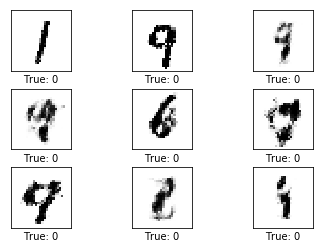

Epoach 20000
Discriminator loss:  0.688181
Generator loss: 2.27882


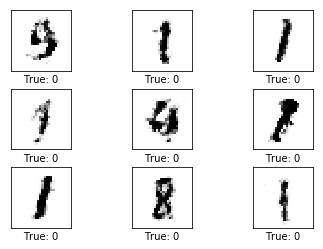

Epoach 21000
Discriminator loss:  0.563558
Generator loss: 2.22866


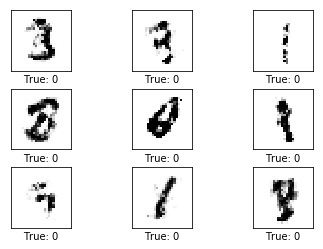

Epoach 22000
Discriminator loss:  0.556418
Generator loss: 2.48775


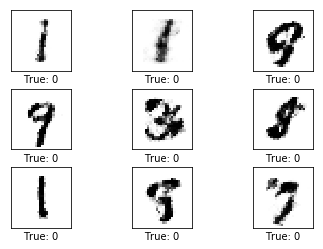

Epoach 23000
Discriminator loss:  0.725296
Generator loss: 2.3223


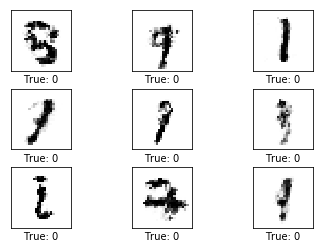

Epoach 24000
Discriminator loss:  0.618834
Generator loss: 2.66265


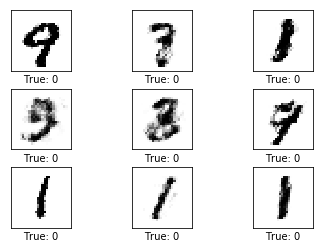

Epoach 25000
Discriminator loss:  0.594209
Generator loss: 2.29481


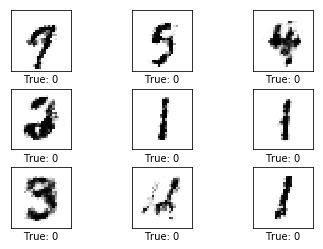

Epoach 26000
Discriminator loss:  0.711861
Generator loss: 2.35846


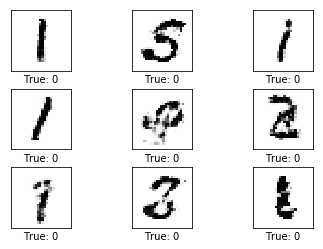

Epoach 27000
Discriminator loss:  0.687482
Generator loss: 2.38586


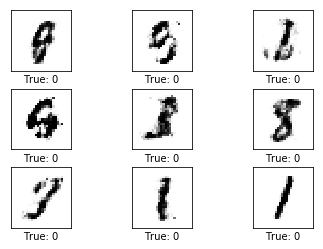

Epoach 28000
Discriminator loss:  0.637445
Generator loss: 2.47301


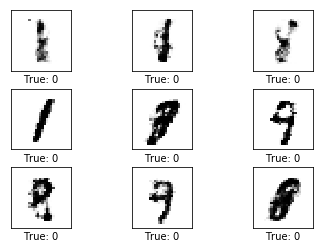

Epoach 29000
Discriminator loss:  0.677728
Generator loss: 2.68832


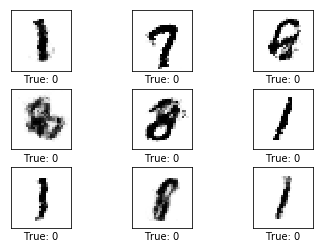

Epoach 30000
Discriminator loss:  0.533565
Generator loss: 2.34963


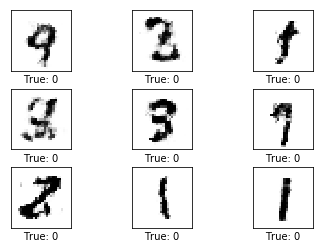

Epoach 31000
Discriminator loss:  0.82848
Generator loss: 1.87586


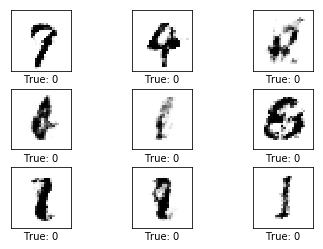

Epoach 32000
Discriminator loss:  0.648489
Generator loss: 2.22176


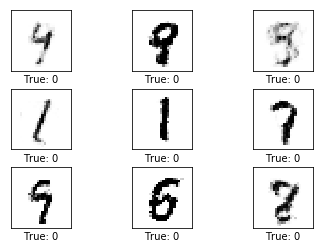

Epoach 33000
Discriminator loss:  0.612108
Generator loss: 2.25646


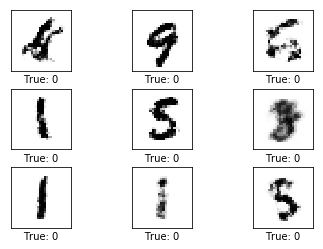

Epoach 34000
Discriminator loss:  0.646127
Generator loss: 2.26013


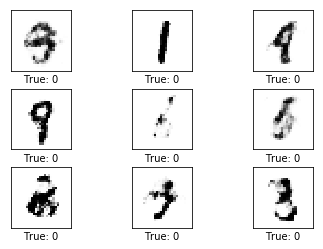

Epoach 35000
Discriminator loss:  0.588446
Generator loss: 2.17806


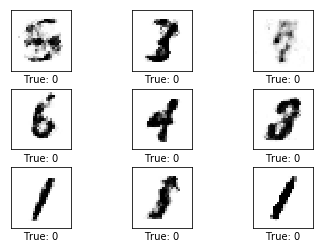

Epoach 36000
Discriminator loss:  0.632421
Generator loss: 2.36299


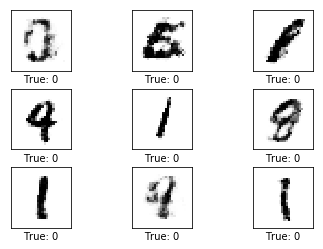

Epoach 37000
Discriminator loss:  0.642034
Generator loss: 2.57661


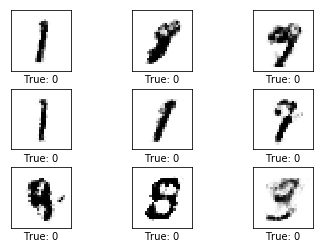

Epoach 38000
Discriminator loss:  0.624625
Generator loss: 2.2332


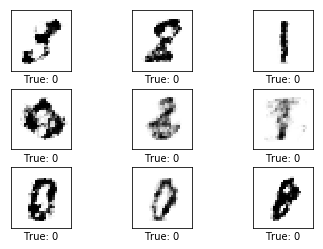

Epoach 39000
Discriminator loss:  0.588076
Generator loss: 2.53618


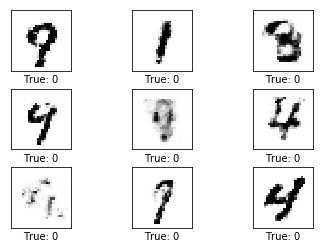

Epoach 40000
Discriminator loss:  0.566012
Generator loss: 2.59025


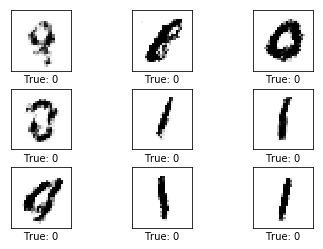

Epoach 41000
Discriminator loss:  0.613208
Generator loss: 2.30831


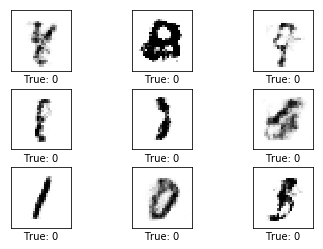

Epoach 42000
Discriminator loss:  0.649716
Generator loss: 2.28965


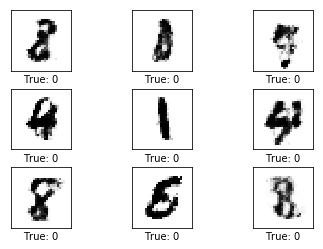

Epoach 43000
Discriminator loss:  0.601197
Generator loss: 2.45037


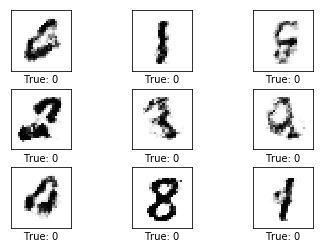

Epoach 44000
Discriminator loss:  0.515022
Generator loss: 2.45554


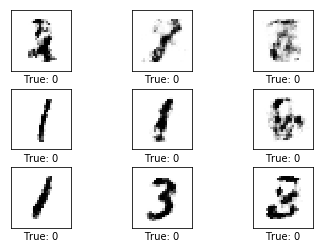

Epoach 45000
Discriminator loss:  0.600091
Generator loss: 2.34599


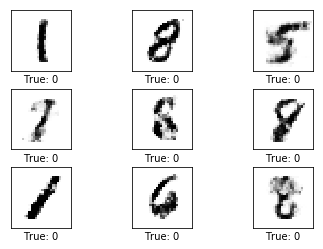

Epoach 46000
Discriminator loss:  0.548281
Generator loss: 2.48786


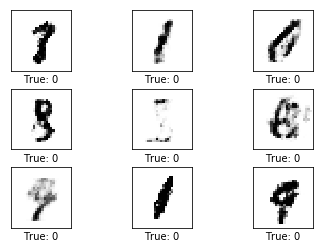

Epoach 47000
Discriminator loss:  0.612543
Generator loss: 2.11299


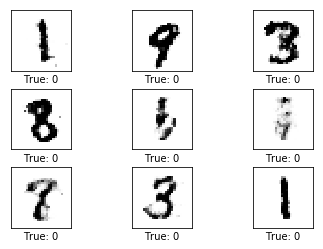

Epoach 48000
Discriminator loss:  0.663862
Generator loss: 2.44754


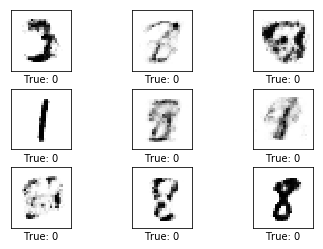

Epoach 49000
Discriminator loss:  0.643021
Generator loss: 2.28167


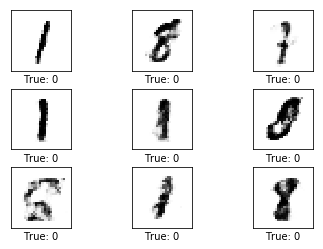

Epoach 50000
Discriminator loss:  0.478065
Generator loss: 2.786


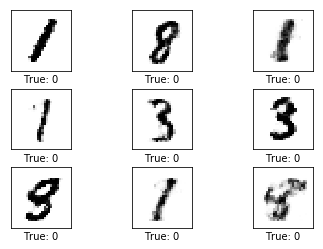

Epoach 51000
Discriminator loss:  0.58287
Generator loss: 2.20967


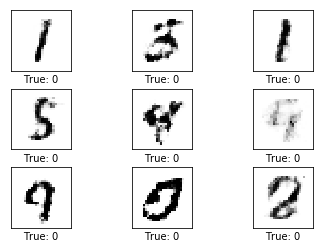

Epoach 52000
Discriminator loss:  0.53276
Generator loss: 2.35882


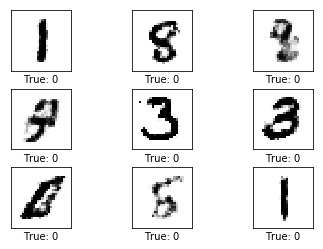

Epoach 53000
Discriminator loss:  0.602549
Generator loss: 2.47548


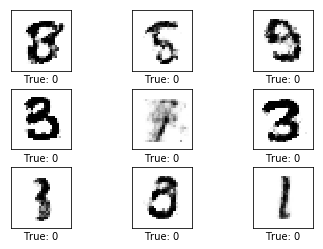

Epoach 54000
Discriminator loss:  0.541285
Generator loss: 2.42903


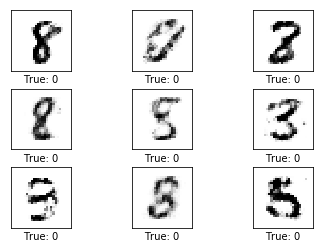

Epoach 55000
Discriminator loss:  0.663221
Generator loss: 2.2037


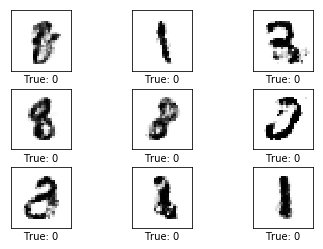

Epoach 56000
Discriminator loss:  0.590333
Generator loss: 2.17652


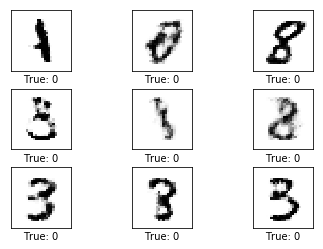

Epoach 57000
Discriminator loss:  0.589793
Generator loss: 2.78653


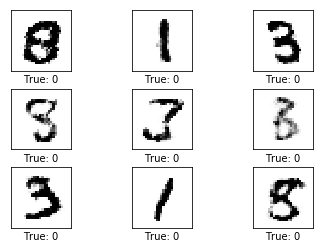

Epoach 58000
Discriminator loss:  0.563289
Generator loss: 2.54329


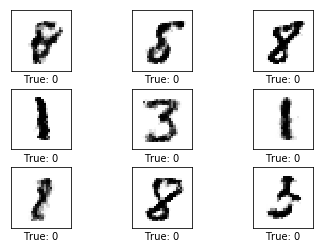

Epoach 59000
Discriminator loss:  0.587301
Generator loss: 2.61899


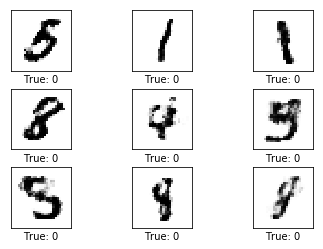

Epoach 60000
Discriminator loss:  0.547113
Generator loss: 2.59451


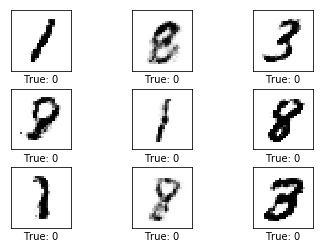

Epoach 61000
Discriminator loss:  0.499588
Generator loss: 2.34323


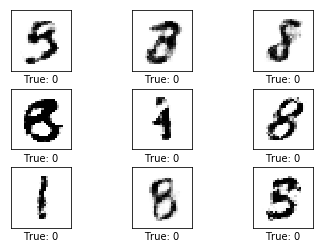

Epoach 62000
Discriminator loss:  0.492702
Generator loss: 2.1853


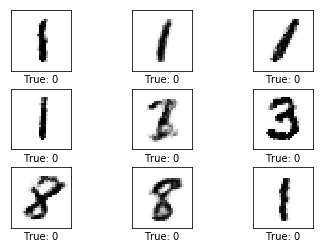

Epoach 63000
Discriminator loss:  0.546465
Generator loss: 2.31968


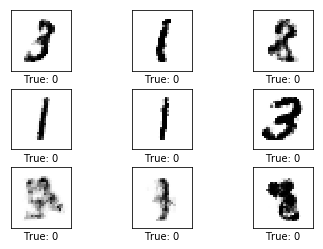

Epoach 64000
Discriminator loss:  0.515767
Generator loss: 2.3798


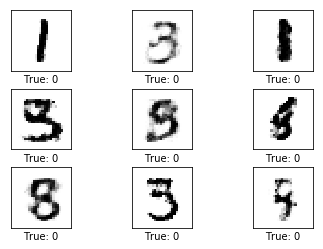

Epoach 65000
Discriminator loss:  0.505154
Generator loss: 2.30813


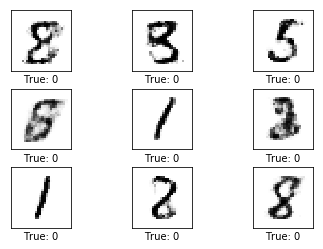

Epoach 66000
Discriminator loss:  0.483525
Generator loss: 2.25767


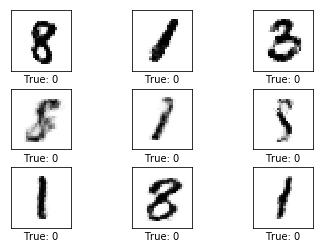

Epoach 67000
Discriminator loss:  0.506471
Generator loss: 2.71711


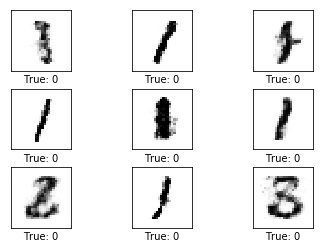

Epoach 68000
Discriminator loss:  0.587313
Generator loss: 2.44508


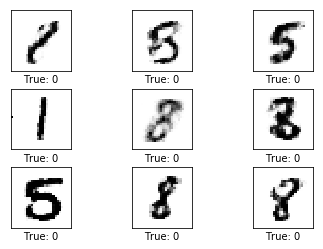

Epoach 69000
Discriminator loss:  0.564545
Generator loss: 2.46253


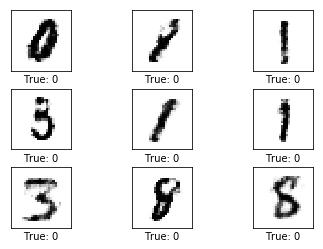

Epoach 70000
Discriminator loss:  0.474788
Generator loss: 2.49688


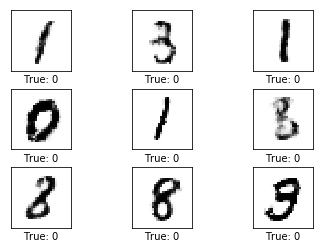

Epoach 71000
Discriminator loss:  0.518086
Generator loss: 2.59245


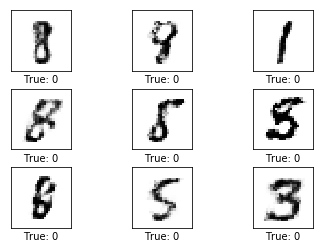

Epoach 72000
Discriminator loss:  0.548335
Generator loss: 2.53841


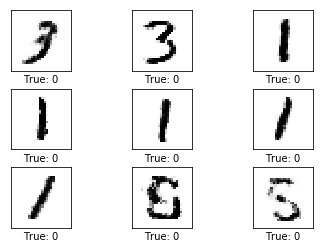

Epoach 73000
Discriminator loss:  0.553723
Generator loss: 2.282


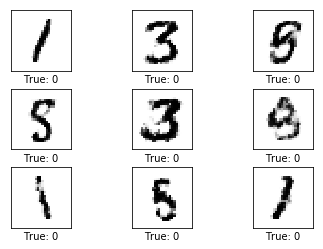

Epoach 74000
Discriminator loss:  0.556227
Generator loss: 2.25359


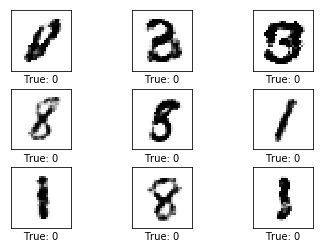

Epoach 75000
Discriminator loss:  0.495804
Generator loss: 2.58923


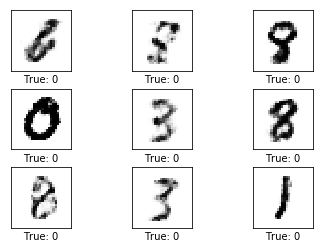

Epoach 76000
Discriminator loss:  0.521988
Generator loss: 2.35466


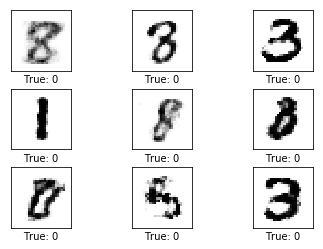

Epoach 77000
Discriminator loss:  0.519065
Generator loss: 2.67895


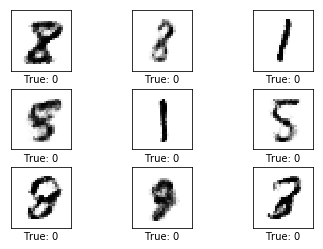

Epoach 78000
Discriminator loss:  0.51773
Generator loss: 2.51226


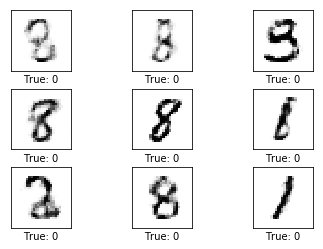

Epoach 79000
Discriminator loss:  0.461173
Generator loss: 2.52842


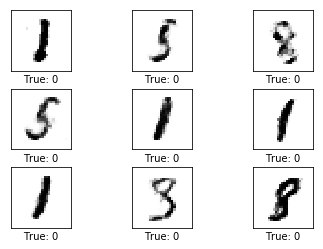

Epoach 80000
Discriminator loss:  0.471385
Generator loss: 2.49159


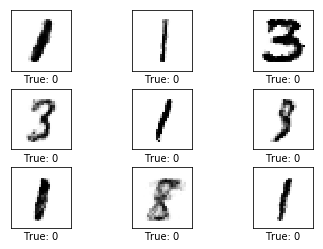

Epoach 81000
Discriminator loss:  0.515441
Generator loss: 2.56262


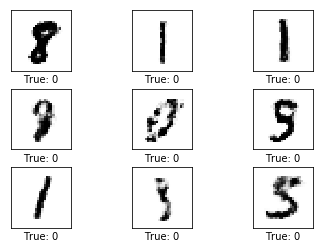

Epoach 82000
Discriminator loss:  0.504266
Generator loss: 2.28932


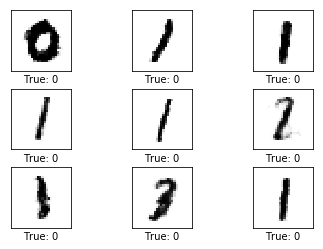

Epoach 83000
Discriminator loss:  0.470762
Generator loss: 2.64031


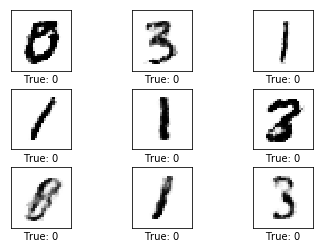

Epoach 84000
Discriminator loss:  0.529249
Generator loss: 2.50415


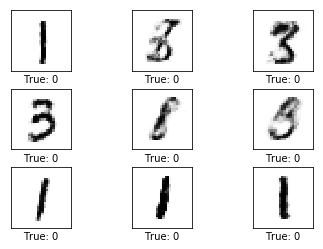

Epoach 85000
Discriminator loss:  0.532108
Generator loss: 2.94733


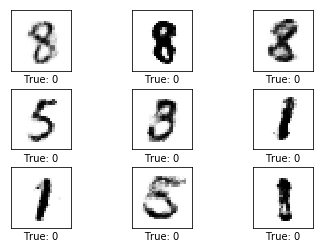

Epoach 86000
Discriminator loss:  0.442505
Generator loss: 2.58019


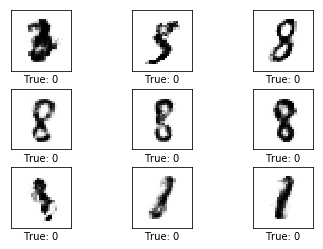

Epoach 87000
Discriminator loss:  0.357984
Generator loss: 2.72019


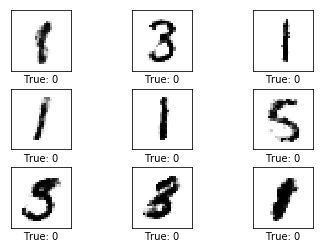

Epoach 88000
Discriminator loss:  0.487376
Generator loss: 2.27182


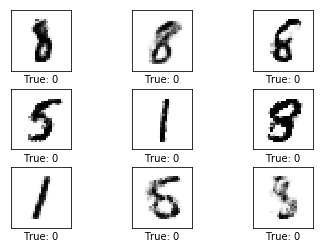

Epoach 89000
Discriminator loss:  0.422788
Generator loss: 2.53527


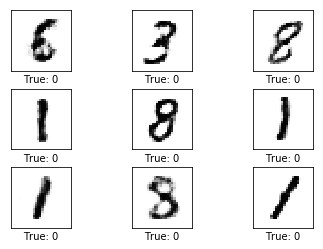

Epoach 90000
Discriminator loss:  0.572876
Generator loss: 2.33011


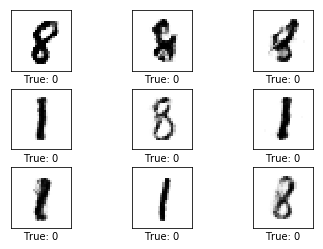

Epoach 91000
Discriminator loss:  0.510257
Generator loss: 2.43353


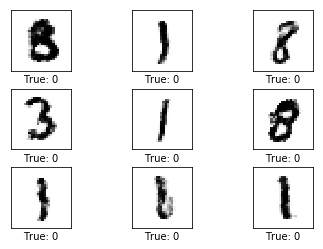

Epoach 92000
Discriminator loss:  0.44078
Generator loss: 2.53855


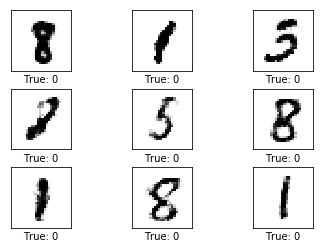

Epoach 93000
Discriminator loss:  0.433996
Generator loss: 2.48501


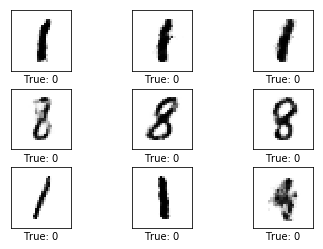

Epoach 94000
Discriminator loss:  0.36338
Generator loss: 2.61082


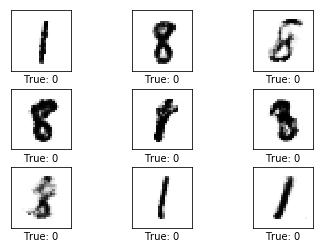

Epoach 95000
Discriminator loss:  0.543079
Generator loss: 2.63407


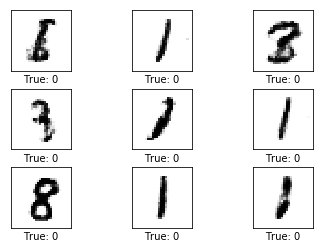

Epoach 96000
Discriminator loss:  0.45473
Generator loss: 2.29724


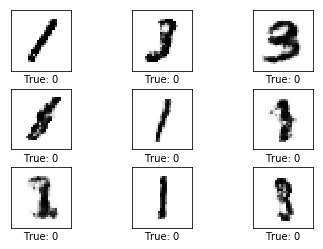

Epoach 97000
Discriminator loss:  0.531981
Generator loss: 2.73853


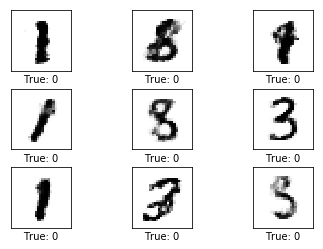

Epoach 98000
Discriminator loss:  0.534324
Generator loss: 2.73073


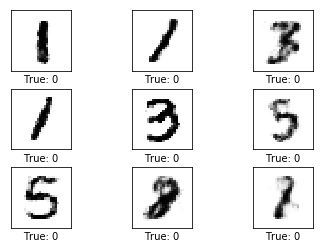

Epoach 99000
Discriminator loss:  0.38476
Generator loss: 2.91491


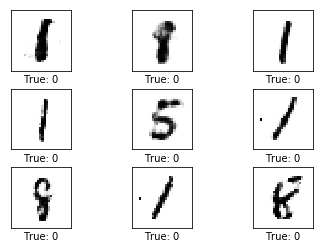

In [7]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=z_dimention):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

## Start graph computations and algorithm


batch_size = 1000
epoach = 10000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach):
    x_train,y_train = mnist.train.next_batch(batch_size)

    #first discriminator
    _, d_loss_value,d_sample = sess.run([d_train_op, d_loss, generated_sample], feed_dict={X: x_train, Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value,g_sample = sess.run([g_train_op, g_loss,generated_sample], feed_dict={Z: random_Z(batch_size)})

    if i%100 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        z_new = random_Z(9)

        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
        ut.plot_mnist_images(generated_images,cls_true=[0]*9)

##After the otimization lets generate some numbers :D 

z_new = random_Z(9)

generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})


#ut.plot_mnist_images(generated_images,cls_true=[0]*9)


[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.37832160e-23   1.03179094e-22   5.12753057e-23 ...,   5.50832414e-23
    5.19145670e-23   1.02800358e-22]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


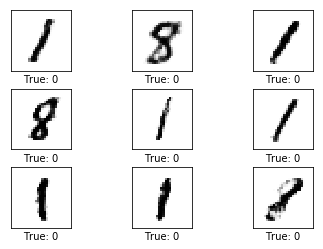

In [8]:


#generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
print(generated_images)
ut.plot_mnist_images(generated_images,cls_true=[0]*9)


### Analysing noise Z

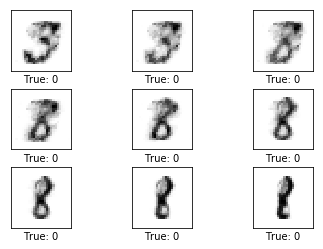

In [41]:
z_noise = np.zeros((9,z_dimention))

range_values = np.arange(-1, 1, 0.23)
for i in range(len(range_values)):
    z_noise[i][:10]=range_values[i]

    
ut.plot_mnist_images(generated_sample.eval(session=sess,feed_dict={Z: z_noise}),cls_true=[0]*9)
